In [1]:
# import functions from ../definitions/definitions_EDA
from datetime import timedelta
import sys
from matplotlib import pyplot as plt
import pandas as pd
from prophet import Prophet
import numpy as np
sys.path.append('../definitions')
import definitions_EDA as eda
# import definitions_plotting as def_plot
from scipy.fft import fft, ifft, fftfreq
from scipy import signal
import shutil
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from scipy.signal import find_peaks
from prophet.plot import plot_plotly, plot_components_plotly
import gc


Define Variables

In [2]:
start_date = pd.Timestamp('2024-03-22')
end_date = pd.Timestamp('2024-03-23')

Fetch data and store as dataframe (data ingestion)

DateTime
2024-03-22    161998
2024-03-23    314396
2024-03-24    269998
2024-03-25    117600
Freq: D, dtype: int64
 
 Shape of df (863992, 6)
 
Number of days data = Total records 863992 / records per day (431998) = 1.9999907406978736 
 
Head of dataframe: 
                          NS_SQUID  Z_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate                DateTime
DateTime                                                                                                
2024-03-22 00:00:00.400  -21.2972  -7.2831    10926.421     -85.7793 -22660.2909 2024-03-22 00:00:00.400
2024-03-22 00:00:00.600  -21.2939  -7.2878    10926.421     -85.7793 -22660.2909 2024-03-22 00:00:00.600
2024-03-22 00:00:00.800  -21.2904  -7.2997    10926.419     -85.7637 -22660.2936 2024-03-22 00:00:00.800
2024-03-22 00:00:01.000  -21.2896  -7.2765    10926.418     -85.5048 -22660.3291 2024-03-22 00:00:01.000
2024-03-22 00:00:01.200  -21.2878  -7.2794    10926.418     -85.5048 -22660.3291 2024-03-22 00:00:01.200


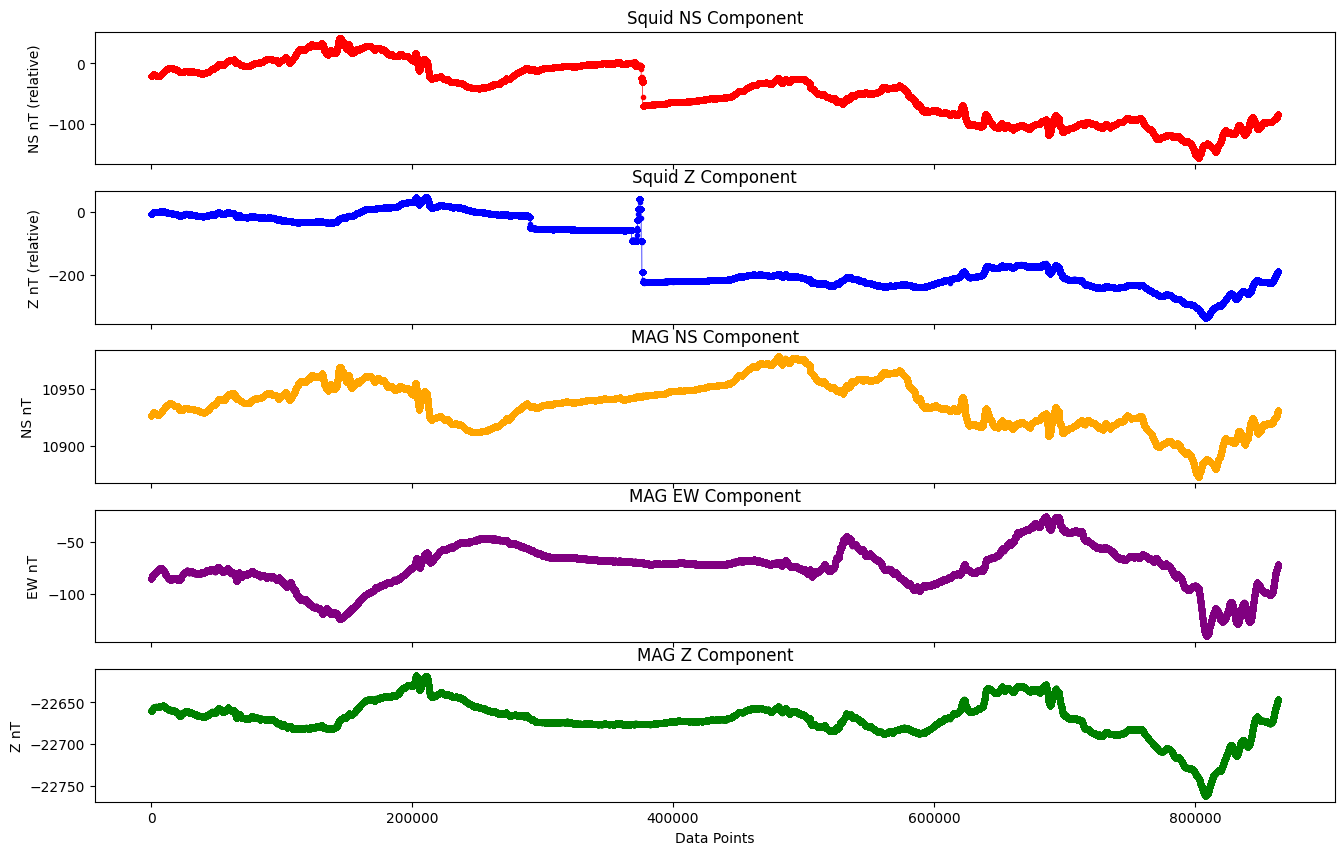

In [3]:
df = eda.get_data(eda.read_txt_file, start_date, end_date)
observations_per_day = df.resample('D').size()
print(observations_per_day)
# df = df.between_time('23:59:50', '00:00:10')
# df = df.astype({'NS_SQUID': 'float32', 'Z_SQUID': 'float32', 'NS_Fluxgate': 'float32', 'EW_Fluxgate': 'float32', 'Z_Fluxgate': 'float32'})
print(f' \n Shape of df', df.shape)
print(f' \nNumber of days data = Total records {df.shape[0]} / records per day (431998) = {df.shape[0]/431998} ')
print(f' \nHead of dataframe: \n', df.head().to_string(index=True))
eda.generateDataPlots(df['NS_SQUID'].values, df['Z_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 431997, start_date, end_date)


# Scale SQUID data

Determine the Offset (Baseline)

Define Quiet Period

In [ ]:
# start_date_quiet = '2024-03-26'
# end_date_quiet = '2024-03-31'

# data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date_quiet, end_date_quiet))
# data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date_quiet, end_date_quiet))
# df_quiet = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date_quiet)
# df_quiet = df_quiet.astype({'NS_SQUID': 'float32', 'Z_SQUID': 'float32', 'NS_Fluxgate': 'float32', 'EW_Fluxgate': 'float32', 'Z_Fluxgate': 'float32'})
# del data_arr_mag, data_arr_squid
# gc.collect()
# # df = df.between_time('12:30:00', '13:30:00') # Select only a small subset of the data for analysis
# # print(f' \n Shape of df', df.shape)
# print(f' \nNumber of days data = Total records {df_quiet.shape[0]} / records per day (431998) = {df_quiet.shape[0]/431998} ')
# print(f' \nHead of dataframe: \n', df_quiet.head().to_string(index=True))


Calculate offset

In [ ]:
# columns  = ["NS_SQUID","Z_SQUID"]
# for column in df_quiet.columns:
#     feature_mean = df_quiet[column].mean()


# Standardise the dataset

Using Z-Score

In [ ]:
for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std()

print(f'New head after standardize\n', df.head())
print(f"Shape after normalisation", df.shape)
eda.generateDataPlots(df['NS_SQUID'].values, df['Z_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, df.shape[0], 431997, start_date, end_date)

### Check for missing values and zero values

In [ ]:
for column in df.columns:
    print(f"\n Number of missing values in {column} is: ", df[column].isna().sum())
    print(f"Nmber of zeros in {column} is: ", (df[column] == 0).sum())

### Outlier Test

Z score test

In [ ]:
print(f' \n Shape of df before removing outliers', df.shape)
outliers_removed_z = eda.z_score_test(df)
print(f' \n Shape of df after removing outliers', outliers_removed_z.shape)
print(f'\nProportion of data removed:', (1-outliers_removed_z.shape[0]/df.shape[0])*100, '%')
del df
gc.collect()
eda.generateDataPlots(outliers_removed_z['NS_SQUID'].values, outliers_removed_z['Z_SQUID'].values, outliers_removed_z['NS_Fluxgate'].values, outliers_removed_z['EW_Fluxgate'].values, outliers_removed_z['Z_Fluxgate'].values, outliers_removed_z.shape[0], 431997, start_date, end_date)

### Fix sudden jumps or drops in the data

As we can see there are severe drops in the squid data. Lets fix these

In [ ]:
corrected_df_ns = eda.detect_spikes_and_correct(outliers_removed_z, "NS_SQUID")
corrected_df_f = eda.detect_spikes_and_correct(corrected_df_ns, "Z_SQUID")
corrected_df_nf = eda.detect_spikes_and_correct(corrected_df_f, "NS_Fluxgate")
corrected_df_ew = eda.detect_spikes_and_correct(corrected_df_nf, "EW_Fluxgate")
corrected_df = eda.detect_spikes_and_correct(corrected_df_ew, "Z_Fluxgate")
del outliers_removed_z, corrected_df_ns, corrected_df_f, corrected_df_nf, corrected_df_ew
gc.collect()
eda.generateDataPlots(corrected_df['NS_SQUID'].values, corrected_df['Z_SQUID'].values, corrected_df['NS_Fluxgate'].values, corrected_df['EW_Fluxgate'].values, corrected_df['Z_Fluxgate'].values, corrected_df.shape[0], 431997, start_date, end_date)

# Feature Generation

Now add the H component

In [ ]:
h_component = np.sqrt(corrected_df['NS_Fluxgate']**2 + corrected_df['EW_Fluxgate']**2)
corrected_df.loc[:,"H Component"] = h_component
# print(corrected_df)
observations_per_day = corrected_df.resample('D').size()
print(observations_per_day)
# print(f"Shape after feature generation:", corrected_df.shape)

# Now Resample

In [ ]:
def resample_time_series(df, start_date, end_date):
  """Resamples time series data from 5Hz to 1 sample per minute for a given date range.

  Args:
    df: Pandas DataFrame containing the time series data.
    start_date: Start date for resampling.
    end_date: End date for resampling.

  Returns:
    Resampled Pandas DataFrame with 1 sample per minute.
  """

  # Filter data for the specified date range
  filtered_df = df[(df.index >= start_date) & (df.index < end_date)]
  print(f"This is the size of the df for day ", start_date," has shape: ", filtered_df.shape)
  # Resample to 1 minute frequency
  resampled_df = filtered_df.resample('min').mean()  # Adjust resampling method as needed

  return resampled_df

resampled_df = pd.DataFrame()
# Resample data for each day
for day in pd.date_range(start_date, end_date, freq='D'):
  resampled_data = resample_time_series(corrected_df, day, day + pd.Timedelta(days=1))
  # Do something with the resampled data, e.g., save to a file
  resampled_data.to_csv(f'/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/MIN DATA/{day.strftime("%Y-%m-%d")}.csv')
  print(f"The shape of day ",day, " in the data is: ", resampled_data.shape)
  resampled_df = pd.concat([resampled_df, resampled_data])

print(f"This is the new resampled dataframe\n", resampled_df)

Test for stationarity

In [ ]:
eda.perform_dickey_fuller_test(resampled_df)

Test for seasonality and trend

In [ ]:
eda.test_stationarity(corrected_df)

Now using the autocorrelation_plot

In [ ]:
# Draw Plot
for column in resampled_df.columns:
    plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
    autocorrelation_plot(resampled_df[column].tolist())
    plt.title(f'Autocorrelation for {column}')
    plt.show()  # Display the plot

Fourier Transform

In [ ]:
components, fourier_results = eda.calculate_fourier_transforms(df)
eda.plot_fourier_transform(fourier_results, components)

Create PDF of each feature

In [ ]:
import seaborn as sns

for column in resampled_df.columns:
    sns.displot(resampled_df[column], kde=True)

Perform Decomposition

In [ ]:
# Additive Decomposition
# result_add = seasonal_decompose(df['Z_Fluxgate'], model='additive', extrapolate_trend='freq')

# Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()

Write the preprocessed dataframe to a file

In [ ]:
resampled_df.to_csv('/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/RESAMPLED/{}-{}.csv'.format(start_date, end_date), index=True)
